### Imports

* Import packages
* Load dataset


#### Import packages

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd
import os

# Import packages for data preprocessing
from sklearn.preprocessing import StandardScaler

# Import packages for data visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.tree import plot_tree
from xgboost import plot_importance 

# Import packages for statistical modeling
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Import packages for machine learning

from pycaret.classification import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Import packages for model evaluation
from sklearn.metrics import (ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, classification_report,
                             confusion_matrix, f1_score, mean_absolute_error, mean_squared_error, precision_score,
                             r2_score, recall_score, roc_auc_score, roc_curve)

# Miscellaneous
from ydata_profiling import ProfileReport


#### Load dataset

In [2]:
cd = os.getcwd()

customer = pd.read_csv(os.path.join(cd, 'olist_customers_dataset.csv'))
geo = pd.read_csv(os.path.join(cd,'olist_geolocation_dataset.csv'))
item = pd.read_csv(os.path.join(cd, 'olist_order_items_dataset.csv'))
payment = pd.read_csv(os.path.join(cd, 'olist_order_payments_dataset.csv'))
review = pd.read_csv(os.path.join(cd, 'olist_order_reviews_dataset.csv'))
order = pd.read_csv(os.path.join(cd, 'olist_orders_dataset.csv'))
product_list = pd.read_csv(os.path.join(cd, 'olist_products_dataset.csv'))
seller = pd.read_csv(os.path.join(cd, 'olist_sellers_dataset.csv'))
product_category = pd.read_csv(os.path.join(cd, 'product_category_name_translation.csv'))

### Data Exploration (Initial EDA and Data Cleaning)

* Understand your variables
* Clean your dataset (missing data, redundant data, outliers)

#### Gather basic information about the data

In [3]:
list_of_df = [customer
              ,geo
              ,item
              ,payment
              ,review
              ,order
              ,product_list
              ,seller
              ,product_category]

for df in list_of_df:
    print(list(df.columns), len(df.columns))

['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state'] 5
['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state'] 5
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value'] 7
['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value'] 5
['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp'] 7
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'] 8
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'] 9
['seller_id', 'seller_zip_code_prefix', 'sell

In [4]:
list_of_df = [customer,
              geo,
              item,
              payment,
              review,
              order,
              product_list,
              seller,
              product_category]

for df in list_of_df:
    print("Columns:", list(df.columns), "Total Columns:", len(df.columns))
    print("Missing Values (per column):")
    print(df.isna().sum())
    print("Total Duplicates:", df.duplicated().sum())
    print("-" * 50)  # Separator for better readability


Columns: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state'] Total Columns: 5
Missing Values (per column):
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
Total Duplicates: 0
--------------------------------------------------
Columns: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state'] Total Columns: 5
Missing Values (per column):
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
Total Duplicates: 261831
--------------------------------------------------
Columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value'] Total Columns: 7
Missing Values (per column):
order_id               0
orde

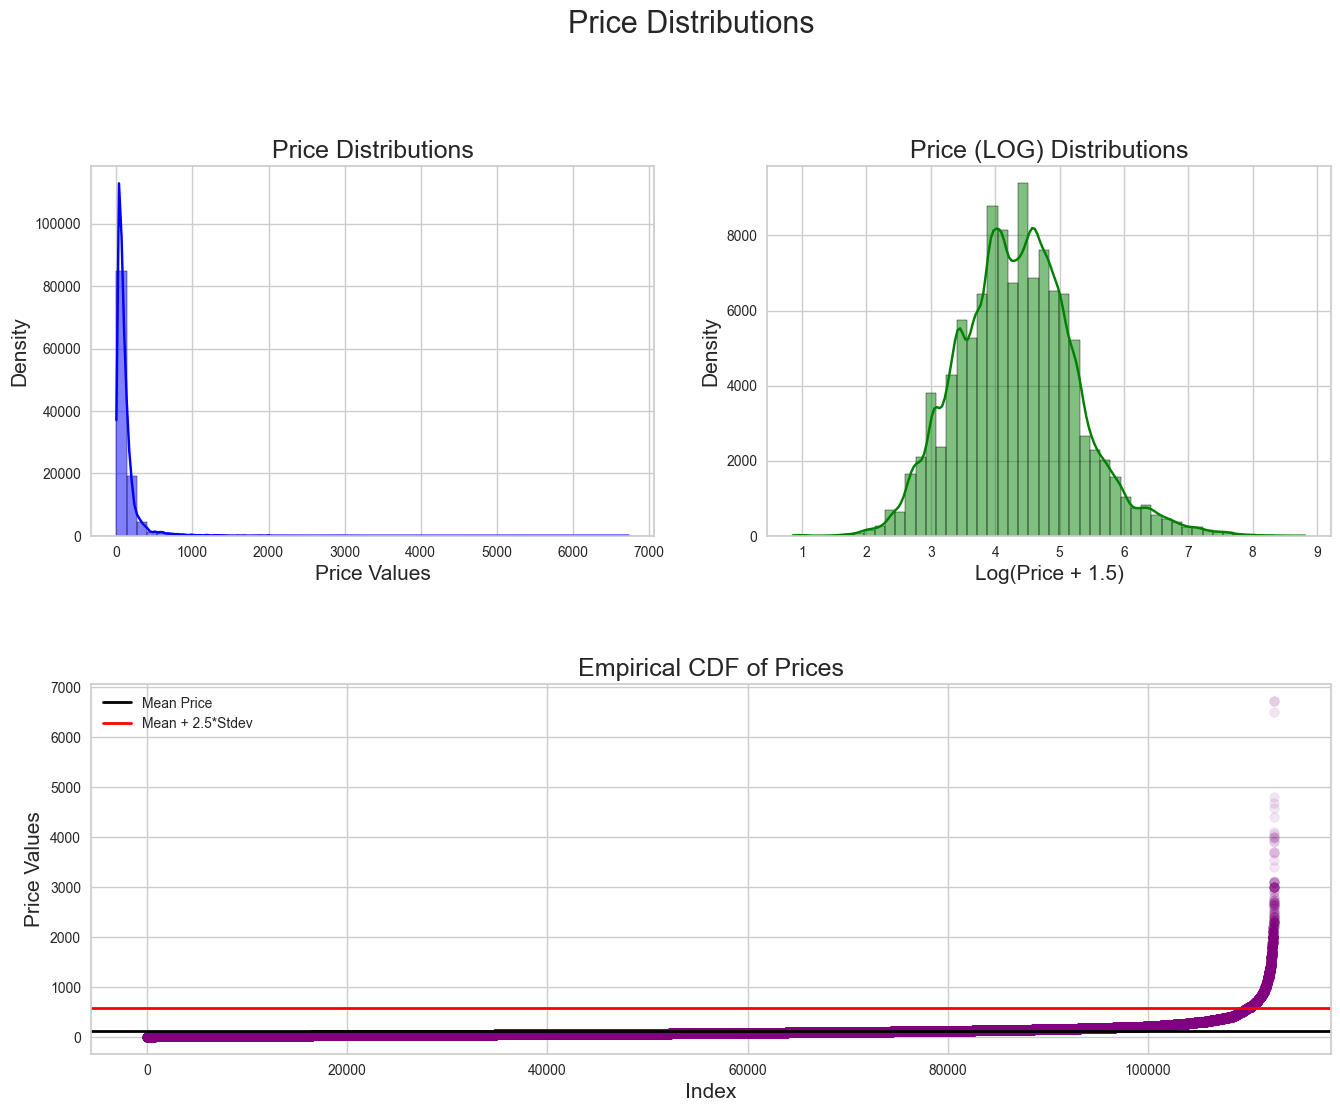

In [5]:
# Assuming 'item' is the DataFrame containing 'price'
item['price'].fillna(-1, inplace=True)

plt.figure(figsize=(16, 12))
plt.suptitle('Price Distributions', fontsize=22)

# Subplot 1: Price Distribution
plt.subplot(221)
g = sns.histplot(item['price'], kde=True, bins=50, color='blue')
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values", fontsize=15)
g.set_ylabel("Density", fontsize=15)

# Subplot 2: Log Price Distribution
plt.subplot(222)
g1 = sns.histplot(np.log(item['price'] + 1.5), kde=True, bins=50, color='green')
g1.set_title("Price (LOG) Distributions", fontsize=18)
g1.set_xlabel("Log(Price + 1.5)", fontsize=15)
g1.set_ylabel("Density", fontsize=15)

# Subplot 3: ECDF of Prices
plt.subplot(212)
g4 = plt.scatter(range(item.shape[0]),
                 np.sort(item['price'].values),
                 alpha=0.1, color='purple')
plt.title("Empirical CDF of Prices", fontsize=18)
plt.xlabel("Index", fontsize=15)
plt.ylabel("Price Values", fontsize=15)
plt.axhline(item[item['price'] != -1]['price'].mean(), color='black',
            label='Mean Price', linewidth=2)
plt.axhline(item[item['price'] != -1]['price'].mean() +
            (2.5 * item[item['price'] != -1]['price'].std()),
            color='red', label='Mean + 2.5*Stdev', linewidth=2)
plt.legend()

plt.subplots_adjust(hspace=0.4, top=0.85)
plt.show()


### Payment Type

In [6]:
payment['price_log'] = np.log(item['price'] + 1.5)

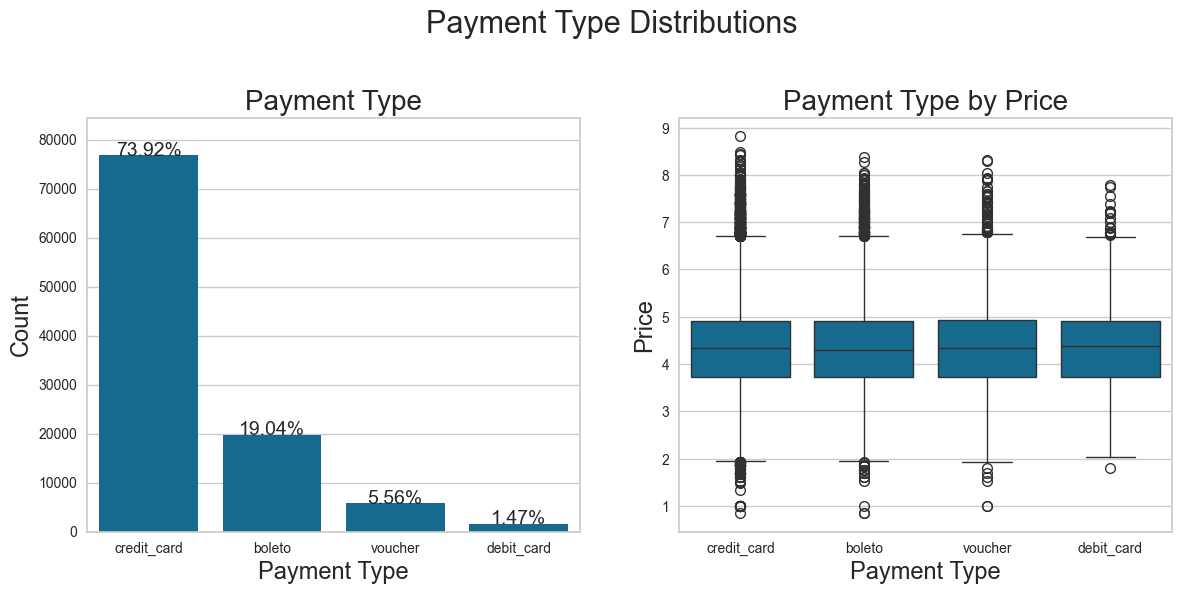

In [7]:
# Create a log-transformed 'price_log' column safely
payment['price_log'] = np.log(item['price'].clip(lower=0) + 1.5)  # Ensures no negative or NaN values

# Calculate the total number of valid entries
total_payment_types = len(payment[payment['payment_type'] != 'not_defined'])

# Set up the figure
plt.figure(figsize=(14, 6))
plt.suptitle('Payment Type Distributions', fontsize=22)

# Subplot 1: Count distribution of payment types
plt.subplot(121)
count_plot = sns.countplot(x='payment_type', data=payment[payment['payment_type'] != 'not_defined'])
count_plot.set_title("Payment Type", fontsize=20)
count_plot.set_xlabel("Payment Type", fontsize=17)
count_plot.set_ylabel("Count", fontsize=17)

# Annotate percentage on each bar
for p in count_plot.patches:
    height = p.get_height()
    percentage = (height / total_payment_types) * 100
    count_plot.text(p.get_x() + p.get_width() / 2, height + 3,
                    f'{percentage:.2f}%', ha="center", fontsize=14)

# Adjust y-axis limit for annotation space
count_plot.set_ylim(0, max(p.get_height() for p in count_plot.patches) * 1.1)

# Subplot 2: Boxplot of price distribution by payment type
plt.subplot(122)
box_plot = sns.boxplot(x='payment_type', y='price_log', data=payment[payment['payment_type'] != 'not_defined'])
box_plot.set_title("Payment Type by Price", fontsize=20)
box_plot.set_xlabel("Payment Type", fontsize=17)
box_plot.set_ylabel("Price", fontsize=17)

# Adjust layout
plt.subplots_adjust(hspace=0.5, top=0.8)
plt.show()


### Conversion Rate

In [8]:
# Assuming total_visitors is provided separately
total_orders = order['order_id'].nunique()

# Correctly calculate total unique visitors
total_visitors = customer['customer_unique_id'].nunique()

# Calculate conversion rate
conversion_rate = (total_orders / total_visitors)
print(f"Conversion Rate: {conversion_rate:.2f}%")

Conversion Rate: 1.03%


### Retention Rate

pas le temps de cherche (to finish if there is time)

In [9]:
# Identify customers with more than one order
customer_order_counts = order.groupby('customer_id')['order_id'].nunique()

# Count returning customers (customers with more than one order)
returning_customers = customer_order_counts[customer_order_counts > 1].count()

# Total unique customers
total_customers = order['customer_id'].nunique()

# Calculate retention rate
retention_rate = (returning_customers / total_customers)
print(f"Retention Rate: {retention_rate:.2f}%")


Retention Rate: 0.00%


### Successful Delivery Rate

In [10]:
# Count successfully delivered orders
successful_deliveries = order[~order['order_delivered_customer_date'].isna()].shape[0]

# Total orders
total_orders = order['order_id'].nunique()

# Successful delivery rate calculation
successful_delivery_rate = (successful_deliveries / total_orders) * 100
print(f"Successful Delivery Rate: {successful_delivery_rate:.2f}%")


Successful Delivery Rate: 97.02%


### RFM ANALYSIS

RFM (Recency, Frequency, Monetary) analysis, helping to:

- Segment customers based on how recently they purchased.
- Identify engaged customers and target them for retention campaigns.
- Focus on reactivating less engaged customers.

#### 1) RECENCY

In [39]:
# getting the latest day of purchase for each user
recency_table = customer.merge(order, on ="customer_id")
recency_table = recency_table.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'max'}).reset_index()
# convert to datetime dtype
recency_table['order_purchase_timestamp'] = pd.to_datetime(recency_table['order_purchase_timestamp'])
# calculate the current day 
current_day = pd.to_datetime(max(order['order_purchase_timestamp']))
# calculate the days between
recency_table['days_between'] = (current_day - recency_table['order_purchase_timestamp']).apply(lambda x: int(str(x).split()[0]))
# def function that scores the data
def scoring(x):
    # calculate quantiles
    quan_val_list = []
    for quan in [0.2,0.4,0.6,0.8]:
        quan_val_list.append(np.quantile(x,quan))
    # label the data base on the quantile value
    def labeling(x):
        if x < quan_val_list[0]: return 1
        elif x < quan_val_list[1]: return 2
        elif x < quan_val_list[2]: return 3
        elif x < quan_val_list[3]: return 4
        else: return 5

    return x.apply(labeling)

recency_table['recency_score'] = scoring(recency_table['days_between'])
recency_table

,customer_unique_id,order_purchase_timestamp,days_between,recency_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,160,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,163,2
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,585,5
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,369,4
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,336,4
...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,495,5
96092,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,310,3
96093,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,617,5
96094,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,168,2


#### 2) FREQUENCY

In [40]:
# merging df
frequency_table = customer.merge(order, on="customer_id")
# getting interested information
frequency_table = frequency_table.groupby('customer_unique_id').agg({
    "order_purchase_timestamp": ['min', 'max'],
    "order_id": 'count'
}).reset_index()
# change columns
frequency_table.columns = ['customer_unique_id', 'min', 'max', 'count']
# change data type
frequency_table['max'] = pd.to_datetime(frequency_table['max'])
frequency_table['min'] = pd.to_datetime(frequency_table['min'])
# days between first and last day of purchase 
frequency_table['days_between'] = (frequency_table['max'] - frequency_table['min']).apply(lambda x: int(str(x).split()[0]))
frequency_table['days_between'].value_counts()
# get rid of one-time-purchase customer
frequency_table = frequency_table[frequency_table['days_between']>0]
# calculate purchase_rate
frequency_table['purchase_rate'] = frequency_table['count'] / frequency_table['days_between']
# score the purchase_rate
frequency_table['frequency_score'] = scoring(frequency_table['purchase_rate'])

#### 3) MONETARY

In [41]:
monetary_table = payment.merge(order, on="order_id").merge(customer, on="customer_id")
monetary_table = monetary_table.groupby('customer_unique_id').agg({'payment_value':'sum'}).reset_index()
monetary_table['monetary_score'] = scoring(monetary_table['payment_value'])
monetary_table

,customer_unique_id,payment_value,monetary_score
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1
2,0000f46a3911fa3c0805444483337064,86.22,2
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,196.89,4
...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,5
96091,fffea47cd6d3cc0a88bd621562a9d061,84.58,2
96092,ffff371b4d645b6ecea244b27531430a,112.46,3
96093,ffff5962728ec6157033ef9805bacc48,133.69,4


#### 4) Combine All

In [48]:
# Merge recency, monetary, and frequency tables to create the final RFM table
final_table = (
    recency_table
    .merge(monetary_table, on='customer_unique_id')
    .merge(frequency_table, on='customer_unique_id')
)

# Select relevant columns for scoring and analysis
final_table = final_table[['customer_unique_id', 'recency_score', 'frequency_score', 'monetary_score']]

# Calculate a combined frequency and monetary score
final_table['frequency_monetary_score'] = scoring(final_table['frequency_score'] + final_table['monetary_score'])

# Retain only necessary columns for segmentation
final_table = final_table[['customer_unique_id', 'recency_score', 'frequency_monetary_score']]

# Define customer segments with professional naming
segment_dict = {
    # Dormant customers
    (1, 1): "Dormant", (1, 2): "Dormant", (2, 1): "Dormant", (2, 2): "Dormant",
    
    # Low-Engagement customers
    (3, 1): "Low Engagement", (3, 2): "Low Engagement",
    
    # Emerging customers
    (4, 1): "Emerging", (5, 1): "Emerging",
    
    # Growth Opportunity customers
    (4, 2): "Growth Opportunity", (4, 3): "Growth Opportunity", (5, 2): "Growth Opportunity", (5, 3): "Growth Opportunity",
    
    # Attention Required customers
    (3, 3): "Attention Required",
    
    # At-Risk customers
    (1, 3): "At Risk", (1, 4): "At Risk", (2, 3): "At Risk", (2, 4): "At Risk",
    
    # Retention Priority customers
    (1, 5): "Retention Priority", (2, 5): "Retention Priority",
    
    # Loyal Advocates
    (3, 4): "Loyal Advocate", (3, 5): "Loyal Advocate", (4, 4): "Loyal Advocate", (4, 5): "Loyal Advocate",
    
    # High-Value Champions
    (5, 4): "High-Value Champion", (5, 5): "High-Value Champion"
}

# Assign customer segments based on scores using the predefined segmentation dictionary
final_table['segment'] = final_table.apply(
    lambda x: segment_dict[(x['recency_score'], x['frequency_monetary_score'])],
    axis=1
)

# Display the final table
final_table


,customer_unique_id,recency_score,frequency_monetary_score,segment
0,00172711b30d52eea8b313a7f2cced02,1,5,Retention Priority
1,004288347e5e88a27ded2bb23747066c,3,3,Attention Required
2,004b45ec5c64187465168251cd1c9c2f,2,1,Dormant
3,0058f300f57d7b93c477a131a59b36c3,2,4,At Risk
4,00a39521eb40f7012db50455bf083460,1,4,At Risk
...,...,...,...,...
2117,ff03923ad1eb9e32304deb7f9b2a45c9,2,5,Retention Priority
2118,ff22e30958c13ffe219db7d711e8f564,1,5,Retention Priority
2119,ff36be26206fffe1eb37afd54c70e18b,1,5,Retention Priority
2120,ff8892f7c26aa0446da53d01b18df463,4,3,Growth Opportunity


In [49]:
final_data = final_table['segment'].value_counts()
final_data

segment
Dormant                456
At Risk                421
Loyal Advocate         371
Retention Priority     261
Growth Opportunity     195
High-Value Champion    161
Low Engagement         122
Attention Required      93
Emerging                42
Name: count, dtype: int64

<BarContainer object of 9 artists>

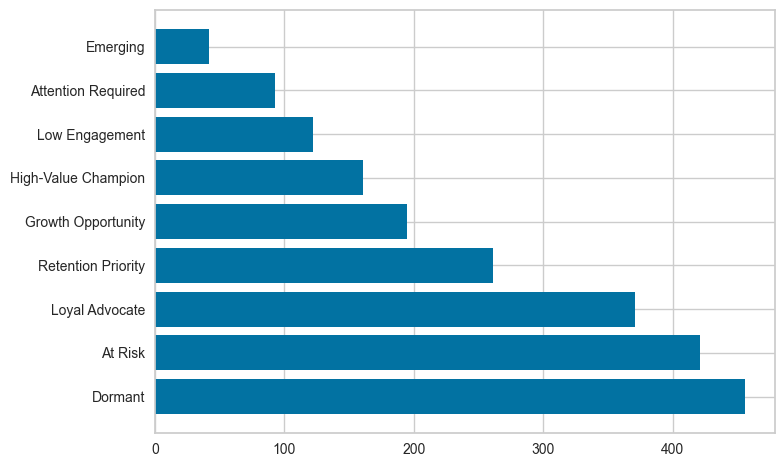

In [50]:
fig, ax = plt.subplots()
ax.barh(
    y =  final_data.index, 
    width =  final_data.values
)

### Products That Are Frequently Bought Together

In [24]:
product_frequency_table = order.merge(item, on="order_id")[['order_id','product_id']]

In [25]:
list_of_item_list = []
for order_id, remaining_df in product_frequency_table.groupby('order_id'):
    list_of_item_list.append(list(remaining_df.drop_duplicates(subset='product_id')['product_id'].values))
list_of_item_list = [list_of_item for list_of_item in list_of_item_list if len(list_of_item) > 1]

In [26]:
from itertools import combinations

com_dict = {}
for list_of_item in list_of_item_list:
    for com in combinations(list_of_item,2):
        if com in com_dict: com_dict[com] +=1
        else: com_dict[com] = 1

res_df = pd.DataFrame(pd.Series(com_dict)).reset_index().rename(columns={'level_0':'item_1', "level_1": "item_2", 0: "count"}).sort_values('count',ascending=False)
top10 = res_df[:10]
top10

,item_1,item_2,count
110,e53e557d5a159f5aa2c5e995dfdf244b,36f60d45225e60c7da4558b070ce4b60,20
740,35afc973633aaeb6b877ff57b2793310,99a4788cb24856965c36a24e339b6058,15
200,36f60d45225e60c7da4558b070ce4b60,e53e557d5a159f5aa2c5e995dfdf244b,14
1552,99a4788cb24856965c36a24e339b6058,35afc973633aaeb6b877ff57b2793310,14
443,f4f67ccaece962d013a4e1d7dc3a61f7,4fcb3d9a5f4871e8362dfedbdb02b064,11
278,422879e10f46682990de24d770e7f83d,389d119b48cf3043d311335e499d9c6b,9
1010,3f14d740544f37ece8a9e7bc8349797e,36f60d45225e60c7da4558b070ce4b60,8
114,4fcb3d9a5f4871e8362dfedbdb02b064,f4f67ccaece962d013a4e1d7dc3a61f7,6
1021,422879e10f46682990de24d770e7f83d,53759a2ecddad2bb87a079a1f1519f73,5
1018,389d119b48cf3043d311335e499d9c6b,53759a2ecddad2bb87a079a1f1519f73,5


### Check for the seasonality

In [28]:
order['order_purchase_timestamp'] = pd.to_datetime(order['order_purchase_timestamp'])
# get the month 'order_purchase_timestamp'
order['month'] = order['order_purchase_timestamp'].dt.strftime("%m")
# merge with payment
seasonality_table = order.merge(payment, on='order_id')
# groupby month, get sum payment_value
seasonality_table = seasonality_table.groupby('month').agg({'payment_value':'mean'}).reset_index()

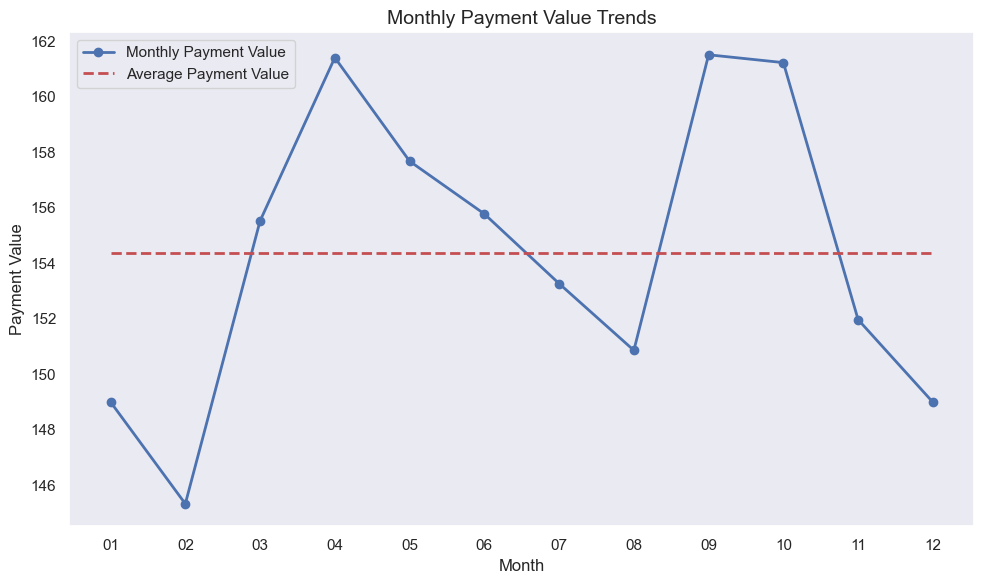

In [30]:
# Visualize the monthly payment value trends
fig, ax = plt.subplots(figsize=(10, 6))  # Set the size of the plot
sns.set_theme(style='darkgrid')  # Apply a professional theme with gridlines for better readability

# Plot the actual monthly payment values
ax.plot(
    seasonality_table['month'],
    seasonality_table['payment_value'],
    label="Monthly Payment Value", color='b', marker='o', linestyle='-', linewidth=2
)

# Plot the average monthly payment value as a reference line
ax.plot(
    seasonality_table['month'],
    [seasonality_table['payment_value'].mean()] * 12,
    label="Average Payment Value", color='r', linestyle='--', linewidth=2
)

# Add labels and title
ax.set_title('Monthly Payment Value Trends', fontsize=14)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Payment Value', fontsize=12)

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


### Feedback Based Rating Predictions

In [61]:
review.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


#### Binary-Labeled Data Preprocessing

In [16]:
def preprocess_binary_labels(data, column_text='review_comment_message', 
                             column_score='review_score', 
                             points_cut=[0, 2, 5], 
                             classes=[0, 1]):
    # Drop rows with missing text
    df_bin = data.dropna(subset=[column_text])
    
    # Bin the scores and assign binary labels
    df_bin['label'] = pd.cut(df_bin[column_score], bins=points_cut, labels=classes)
    
    # Rename and retain necessary columns
    df_bin = df_bin.rename(columns={column_text: 'text'})
    df_bin = df_bin[['text', 'label']]
    
    return df_bin

#### Categorical-Labeled Data Preprocessing

In [17]:
def preprocess_categorical_labels(data, column_text='review_comment_message', 
                                  column_score='review_score'):
    # Drop rows with missing text
    df_cat = data.dropna(subset=[column_text])
    
    # Rename columns and retain necessary columns
    df_cat = df_cat.rename(columns={column_text: 'text', column_score: 'label'})
    df_cat = df_cat[['text', 'label']]
    
    return df_cat

In [18]:
# Binary dataset
data_bin = preprocess_binary_labels(review)

# Categorical dataset
df_cat = preprocess_categorical_labels(review)

In [19]:
import plotly.express as px
import numpy as np

# Assuming `df_cat` is the categorical-labeled data returned from preprocess_categorical_labels
# If you're using the binary-labeled data, replace `df_cat` with the binary dataset (df_bin).

# Count occurrences of each label in the categorical dataset
label_counts = df_cat['label'].value_counts().sort_index()

# Create a bar plot using Plotly
fig = px.bar(
    x=label_counts.index,  # Categories in 'label'
    y=label_counts.values,  # Corresponding counts
    color=label_counts.index,  # Use the label as the color
    color_continuous_scale="Viridis"  # Color scheme
)

# Update axis labels and title
fig.update_xaxes(title="Ratings")
fig.update_yaxes(title="Number of Reviews")
fig.update_layout(
    showlegend=True,
    title={
        'text': 'Rating vs Number of Reviews',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# Show the plot
fig.show()


In [20]:
# Assuming `data_bin` is the binary-labeled dataset
label_counts = data_bin['label'].value_counts().sort_index()

# Create a bar plot using Plotly
fig = px.bar(
    x=label_counts.index,  # Categories in 'label'
    y=label_counts.values,  # Corresponding counts
    color=label_counts.index,  # Use the label as the color
    color_continuous_scale="Viridis"  # Professional color scheme
)

# Update axes titles and layout
fig.update_xaxes(title="Ratings")
fig.update_yaxes(title="Number of Reviews")
fig.update_layout(
    showlegend=True,
    title={
        'text': 'Rating vs No of Reviews',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()


### Split data

In [21]:
from sklearn.model_selection import train_test_split
import numpy as np

def split_data(data, text_column='text', label_column='label', test_size=0.2, random_state=None):

    # Ensure the text and label columns are available in the dataset
    if text_column not in data.columns or label_column not in data.columns:
        raise ValueError(f"Columns {text_column} or {label_column} not found in the dataset.")

    # Split the data into training and testing sets using train_test_split
    X = data[text_column].astype(str)  # Convert text column to string
    y = data[label_column]

    # Perform the split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, y_train, X_test, y_test


# Example usage
X_train, y_train, X_test, y_test = split_data(data_bin, text_column='text', label_column='label', test_size=0.2, random_state=42)
